In [1]:
%env KMP_DUPLICATE_LIB_OK=TRUE 
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from nfmd import NFMD

# Pull out common plotting settings:
from plot_params import get_plot_params
full_params, half_params = get_plot_params()
plt.rcParams.update(full_params)

env: KMP_DUPLICATE_LIB_OK=TRUE


In [2]:
fs = 10e3
t_min = 0
t_max = 1
n = int(t_max*fs)

# Time vector
t = np.linspace(int(t_min*fs), int(t_max*fs), n)
t /= fs
dt = t[1]-t[0]


# Define a time-dependent phase function
omega_1 = 100
amp_1 = 1
z_1 = lambda t: amp_1*np.cos(2*np.pi*omega_1*t)

# Signal mean:
t_p = 0.5
alpha = 1
tau = 0.05
mu = lambda x: np.heaviside(x-t_p, 0)*alpha*(1-np.exp(-(x-t_p)/tau))

# Set the signal:
z = z_1(t) + mu(t)

In [3]:
%%time

###############
# Nonstationary Fourier Mode Decomposition
###############
win_size = 102

nfmd = NFMD(z/np.std(z),
            num_freqs = 2,
            window_size=win_size,
            optimizer_opts={'lr': 1e-03},
            max_iters=100,
            target_loss=1e-3) # target_loss=5e-4)

freqs, A, losses, indices = nfmd.decompose_signal(500)

n_freqs = nfmd.correct_frequencies(dt=dt)
n_amps = nfmd.compute_amps()
n_mean = nfmd.compute_mean()

0/9899|500/9899|1000/9899|1500/9899|2000/9899|2500/9899|3000/9899|3500/9899|4000/9899|4500/9899|5000/9899|5500/9899|6000/9899|6500/9899|7000/9899|7500/9899|8000/9899|8500/9899|9000/9899|9500/9899|Wall time: 5.67 s


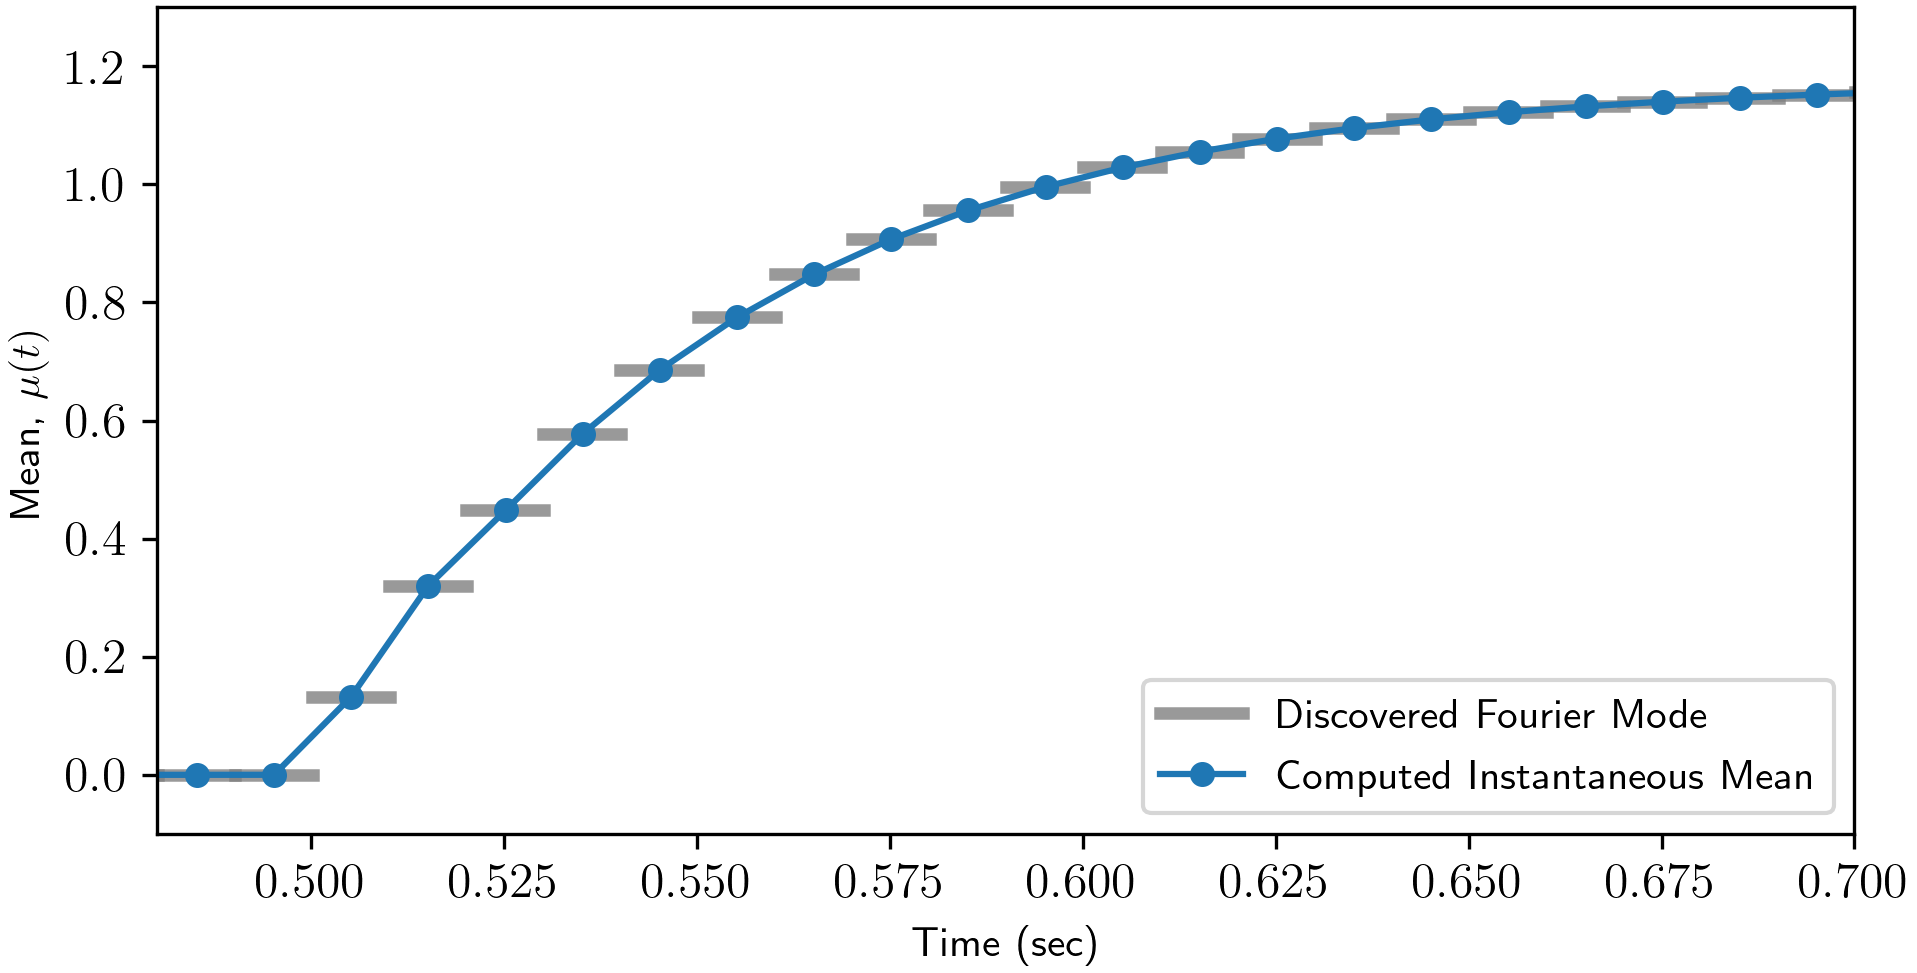

In [4]:
# Initialize empty array
means = np.ndarray(len(nfmd.mid_idcs))
modes = []
modes_t = []

# Determine the low-frequency mode:
lf_mode = 1
mid_idx = int(nfmd.window_size/2)

# Iterate through each fourier object and compute the mean
for i in range(len(nfmd.mid_idcs)):
    # Grab the frequency and the amplitudes
    freq = nfmd.freqs[i, lf_mode]
    A = nfmd.A[i, lf_mode::nfmd.num_freqs]
    # Compute the estimate
    t_window = np.expand_dims(np.arange(nfmd.window_size), -1)
    Omega = np.concatenate([np.cos(t_window*2*np.pi*freq),
                            np.sin(t_window*2*np.pi*freq)], -1)
    fit = np.dot(Omega, A)
    # Add the 'fit' to the modes:
    modes.append(fit.copy())
    # Grab the centerpoint and add it to the means list
    means[i] = fit[mid_idx]
    # set the times for the mode:
    modes_t.append(t[nfmd.indices[i]])


means_t = t[nfmd.mid_idcs]

plt.figure()

skip = 100
up_to = None
for mode_t, mode in zip(modes_t[::skip][:up_to], modes[::skip][:up_to]):
    l1=plt.plot(mode_t, mode, alpha=0.8, color='grey', lw=3)
    
l2=plt.plot(means_t[::skip][:up_to], means[::skip][:up_to], marker='o', markersize=5)
plt.xlim([0.48,0.7])
plt.ylim([-0.1,1.3])

plt.legend(handles=[l1[0],l2[0]], labels=['Discovered Fourier Mode','Computed Instantaneous Mean'], loc='lower right')

plt.ylabel('Mean, $\mu(t)$')
plt.xlabel('Time (sec)')

plt.show()